# Model Evaluation

In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Test data
df = pd.DataFrame(np.random.rand(1000, 2))
df["TrueLabel"] = (df[0] + df[1] > 1).astype(int)
df["PredLabel"] = ((df[0] + df[1] > 0.9) & (df[0] + df[1] < 1.9)).astype(int)
df["FakePredProb"] = np.where(df["PredLabel"], 0.5 + np.random.rand(1000) / 2 , np.random.rand(1000) / 2)

x = df[[0, 1]]
y = df["TrueLabel"]
pred = df["PredLabel"]
pred_probs = df["FakePredProb"]

print(x.head())
print()
print(y.head())
print()
print(pred.head())
print()
print(pred_probs.head())

          0         1
0  0.374540  0.950714
1  0.731994  0.598658
2  0.156019  0.155995
3  0.058084  0.866176
4  0.601115  0.708073

0    1
1    1
2    0
3    0
4    1
Name: TrueLabel, dtype: int32

0    1
1    1
2    0
3    1
4    1
Name: PredLabel, dtype: int32

0    0.630853
1    0.623489
2    0.125234
3    0.624773
4    0.635975
Name: FakePredProb, dtype: float64


### Confusion Matrix

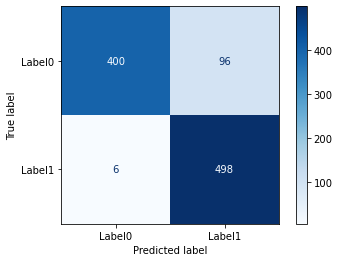

In [2]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# See also: plot_confusion_matrix(estimator, x, y)
cm = confusion_matrix(y, pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Label0", "Label1"])
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

### Receiver Operating Characteristic (ROC)

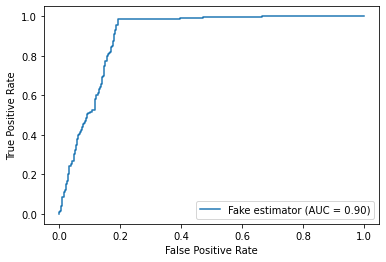

In [3]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# See also: plot_roc_curve(estimator, x, y)
fpr, tpr, thresholds = roc_curve(y, pred_probs)

roc_auc = auc(fpr, tpr)  # Area under Curve
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Fake estimator")
disp.plot()
plt.show()

### Calibration Curve

In [4]:
from sklearn.calibration import calibration_curve


def get_multiple_calibration_plot(predicted_proba_arrays, true_y, figsize=(10, 8)):
    """
    Inspired by sklearn example
    https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    :param figsize: size of the output figure
    :param predicted_proba_y: the predicted probabilities of our model for each example
    :param true_y: the true value of the label
    :return: calibration plot
    """

    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    for i,predicted_proba_y in enumerate(predicted_proba_arrays):
        fraction_of_positives, mean_predicted_value = calibration_curve(
            true_y, predicted_proba_y, n_bins=10
        )

        ax1.plot(
            mean_predicted_value,
            fraction_of_positives,
            "s-",
            label = "Model %s" % (i + 1)
        )

        ax2.hist(
            predicted_proba_y,
            range=(0, 1),
            bins=10,
            histtype="step",
            label = "Model %s" % (i + 1),
            lw=2,
        )

    ax1.set_ylabel("Fraction of positives")
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.legend(loc="lower right")
    ax1.set_title("Calibration plot")

    ax2.set_title("Probability distribution")
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper right", ncol=2)

    plt.tight_layout()

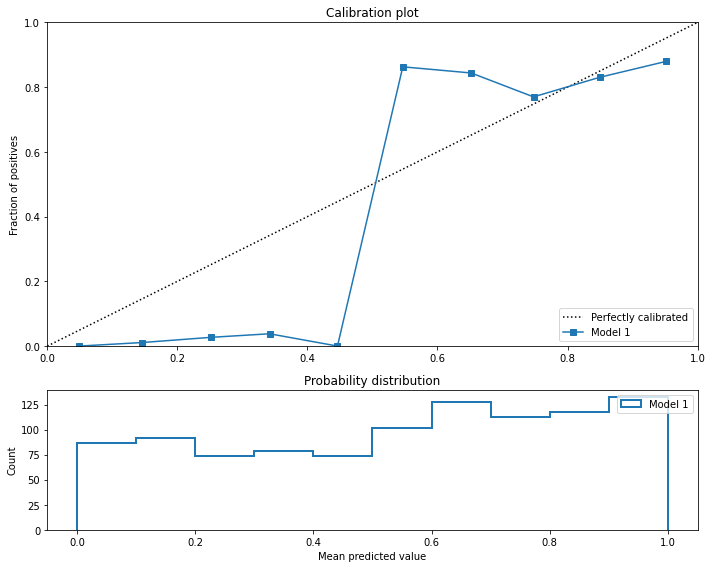

In [5]:
predictions = [pred_probs]
get_multiple_calibration_plot(predictions, y)

### Top-K exploration

In [6]:
def get_top_k(df, proba_col, true_label_col, k=5, decision_threshold=0.5):
    """
    For binary classification problems
    Returns k most correct and incorrect example for each class
    Also returns k most unsure examples
    :param df: DataFrame containing predictions, and true labels
    :param proba_col: column name of predicted probabilities
    :param true_label_col: column name of true labels
    :param k: number of examples to show for each category
    :param decision_threshold: classifier decision boundary to classify as
    positive
    :return: correct_pos, correct_neg, incorrect_pos, incorrect_neg, unsure
    """
    
    correct = df[(df[proba_col] > decision_threshold) == df[true_label_col]].copy()
    incorrect = df[(df[proba_col] > decision_threshold) != df[true_label_col]].copy()

    top_correct_positive = correct[correct[true_label_col] == 1].nlargest(k, proba_col)
    top_correct_negative = correct[correct[true_label_col] == 0].nsmallest(k, proba_col)

    top_incorrect_positive = incorrect[incorrect[true_label_col] == 1].nsmallest(k, proba_col)
    top_incorrect_negative = incorrect[incorrect[true_label_col] == 0].nlargest(k, proba_col)

    # Get closest examples to decision threshold
    most_uncertain = df.iloc[(df[proba_col] - decision_threshold).abs().argsort()[:k]]

    return (
        top_correct_positive,
        top_correct_negative,
        top_incorrect_positive,
        top_incorrect_negative,
        most_uncertain,
    )

In [7]:
get_top_k(df, "FakePredProb", "TrueLabel")

(            0         1  TrueLabel  PredLabel  FakePredProb
 529  0.479876  0.627505          1          1      0.998910
 789  0.607094  0.546697          1          1      0.997410
 460  0.868468  0.487431          1          1      0.996924
 836  0.868057  0.805925          1          1      0.996628
 736  0.878516  0.404140          1          1      0.995664,
             0         1  TrueLabel  PredLabel  FakePredProb
 626  0.117308  0.125186          0          0      0.000327
 217  0.084107  0.700969          0          0      0.000996
 317  0.107172  0.447412          0          0      0.002657
 744  0.388558  0.448694          0          0      0.003439
 710  0.316156  0.507235          0          0      0.005142,
             0         1  TrueLabel  PredLabel  FakePredProb
 598  0.973489  0.968878          1          0      0.186087
 819  0.992484  0.927001          1          0      0.238675
 977  0.998348  0.933113          1          0      0.274934
 932  0.984670  0.9373